In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
import pandas as pd
import torch
import numpy as np

In [104]:
df = pd.read_csv('/content/drive/MyDrive/ml-labs/adult.csv')

Так как данный датасет используется в части лабораторных работ, то опущу этап изучения датасета

In [106]:
df[df == '?'] = np.nan


for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

<ipython-input-106-839e813fca23>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [107]:
X = df.drop(['income'], axis=1)

y = df['income']

In [108]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

In [109]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat = encoder.fit_transform(X[categorical_cols])

scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_cols])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [111]:
X_processed = np.hstack((X_num, X_cat))

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

In [114]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

Данные нейронной сети:


*   2 слоя
*   Функция активации: ReLU
* Оптимизатор Adam
* Функция потерь: Cross entropy



In [115]:
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
train_losses = []

model = Net(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(500):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 0.6765
Epoch 10 | Loss: 0.5791
Epoch 20 | Loss: 0.4968
Epoch 30 | Loss: 0.4350
Epoch 40 | Loss: 0.3904
Epoch 50 | Loss: 0.3605
Epoch 60 | Loss: 0.3443
Epoch 70 | Loss: 0.3353
Epoch 80 | Loss: 0.3300
Epoch 90 | Loss: 0.3261
Epoch 100 | Loss: 0.3232
Epoch 110 | Loss: 0.3209
Epoch 120 | Loss: 0.3189
Epoch 130 | Loss: 0.3172
Epoch 140 | Loss: 0.3157
Epoch 150 | Loss: 0.3144
Epoch 160 | Loss: 0.3131
Epoch 170 | Loss: 0.3119
Epoch 180 | Loss: 0.3109
Epoch 190 | Loss: 0.3099
Epoch 200 | Loss: 0.3090
Epoch 210 | Loss: 0.3082
Epoch 220 | Loss: 0.3074
Epoch 230 | Loss: 0.3066
Epoch 240 | Loss: 0.3059
Epoch 250 | Loss: 0.3052
Epoch 260 | Loss: 0.3045
Epoch 270 | Loss: 0.3039
Epoch 280 | Loss: 0.3032
Epoch 290 | Loss: 0.3026
Epoch 300 | Loss: 0.3020
Epoch 310 | Loss: 0.3013
Epoch 320 | Loss: 0.3007
Epoch 330 | Loss: 0.3001
Epoch 340 | Loss: 0.2995
Epoch 350 | Loss: 0.2989
Epoch 360 | Loss: 0.2983
Epoch 370 | Loss: 0.2977
Epoch 380 | Loss: 0.2971
Epoch 390 | Loss: 0.2965
Epoch 400 |

In [116]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

with torch.no_grad():
    y_pred = model(X_test)
    predicted_classes = torch.argmax(y_pred, dim=1)
    accuracy = accuracy_score(y_test, predicted_classes)
    print(f"Model accuracy score: {accuracy}")

Model accuracy score: 0.8538307999385844


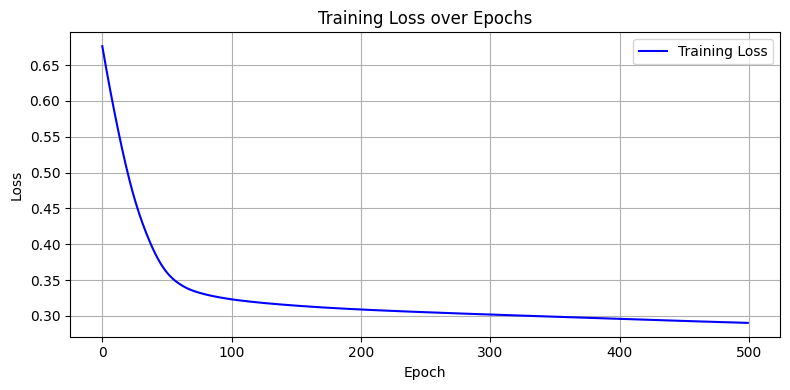

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике видно, что можно ~ 100 эпох, так как ошибка падает медленнее

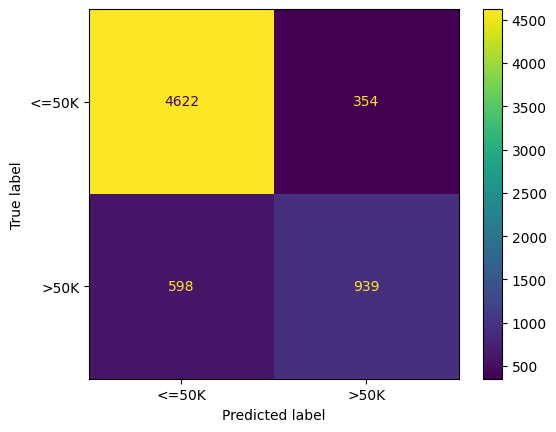

In [118]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

with torch.no_grad():
    y_logits = model(X_test)
    y_pred = torch.argmax(y_logits, dim=1)

conf_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
cm_display.plot()